In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Part 2: Exploratory Data Analysis
Using your scraped data, investigates different relationships between candidates and the amount of money they raised. Here are some suggestions to get you started, but feel free to pose you own questions or do additional exploration:  
    a. How often does the candidate who raised more money win a race?  
    b. How often does the candidate who spent more money win a race?  
    c. Does the difference between either money raised or money spent seem to influence the likelihood of a candidate winning a race?  
    d. How often does the incumbent candidate win a race?  
    e. Can you detect any relationship between amount of money raised and the incumbent status of a candidate?

In [3]:
os.chdir('..')
print(f'current working directory is {os.getcwd()}')

current working directory is C:\Users\lexil\Documents\NSS_Projects\open-secrets-three-musketeers


In [4]:
full_df = pd.read_csv('../open-secrets-three-musketeers/data/full_df.csv')

In [5]:
df_dropped_columns = full_df.drop(columns=['Incumbent', 'IncCID', 'capeye', 'SmLgIndivsNote', 'DistIDCurr', 'PACs', 'Indivs', 'Cand', 'Other', 'ReleaseDate', 'enddate'])

In [6]:
df_clean = df_dropped_columns.rename(columns={'Rcpts': 'Money_Raised', 'Spent': 'Money_Spent', 'CRPICO': 'Candidate_Type'})

How often does the candidate who raised more money win a race?

would we loop through wins over losses in a specific district and then calculate the probability?

In [8]:
df_clean['Result'] = df_clean['Result'].replace(r'^\s*$', np.nan, regex=True).replace(0, np.nan)
df_clean = df_clean.dropna()
df_clean

,cid,FirstLastP,Money_Raised,Money_Spent,EndCash,LgIndivs,SmIndivs,VotePercent,Result,Candidate_Type,State,primarydate,sort,District,State_Abv
0,N00044245,Jerry Carl (R),1971321.50,1859348.91,111972.59,999616.34,44579.61,64.88,W,O,Alabama,2020-03-03 00:00:00 +0000,2,1,AL
1,N00044750,James Averhart (D),80094.95,78973.24,1121.71,37954.77,12895.18,35.04,L,O,Alabama,2020-03-03 00:00:00 +0000,2,1,AL
2,N00041295,Barry Moore (R),650806.75,669367.70,-13633.28,346328.65,62207.55,65.30,W,O,Alabama,2020-03-03 00:00:00 +0000,2,2,AL
3,N00045944,Phyllis Harvey-Hall (D),56049.68,55988.07,0.00,27105.15,15306.80,34.61,L,O,Alabama,2020-03-03 00:00:00 +0000,2,2,AL
5,N00024759,Mike D Rogers (R),1193111.43,1218563.76,502233.70,438054.00,5315.00,67.54,W,I,Alabama,2020-03-03 00:00:00 +0000,1,3,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,N00045620,Tricia Zunker (D),1261957.30,1232690.26,29267.04,566859.76,600014.91,39.24,L,C,Wisconsin,2020-08-11 00:00:00 +0000,2,7,WI
1257,N00039330,Mike Gallagher (R),3202904.74,2841800.71,1169361.53,2040298.63,188430.08,63.98,W,I,Wisconsin,2020-08-11 00:00:00 +0000,1,8,WI
1258,N00045078,Amanda Stuck (D),416978.45,399915.94,2164.80,221453.03,169379.57,36.02,L,C,Wisconsin,2020-08-11 00:00:00 +0000,2,8,WI
1259,N00035504,Liz Cheney (R),3003883.34,3060166.78,153567.15,980348.72,189646.74,68.60,W,I,Wyoming,2020-08-18 00:00:00 +0000,1,1,WY


In [15]:
row_to_drop = df_clean[(df_clean['Money_Raised'] < 0) & (df_clean['cid'] == 'N00043369')]

# Drop the row from clean_df using the index of the row to drop
df_clean = df_clean.drop(row_to_drop.index)

print(df_clean)

            cid               FirstLastP  Money_Raised  Money_Spent  \
0     N00044245           Jerry Carl (R)    1971321.50   1859348.91   
1     N00044750       James Averhart (D)      80094.95     78973.24   
2     N00041295          Barry Moore (R)     650806.75    669367.70   
3     N00045944  Phyllis Harvey-Hall (D)      56049.68     55988.07   
5     N00024759        Mike D Rogers (R)    1193111.43   1218563.76   
...         ...                      ...           ...          ...   
1256  N00045620        Tricia Zunker (D)    1261957.30   1232690.26   
1257  N00039330       Mike Gallagher (R)    3202904.74   2841800.71   
1258  N00045078         Amanda Stuck (D)     416978.45    399915.94   
1259  N00035504           Liz Cheney (R)    3003883.34   3060166.78   
1260  N00047272   Lynnette Grey Bull (D)     134597.32    132234.75   

         EndCash    LgIndivs   SmIndivs  VotePercent Result Candidate_Type  \
0      111972.59   999616.34   44579.61        64.88      W          

In [17]:
print(df_clean[(df_clean['Money_Raised'] < 0) & (df_clean['cid'] == 'N00043369')])

Empty DataFrame
Columns: [cid, FirstLastP, Money_Raised, Money_Spent, EndCash, LgIndivs, SmIndivs, VotePercent, Result, Candidate_Type, State, primarydate, sort, District, State_Abv]
Index: []


In [19]:
df_clean['Result'] = df_clean['Result'].replace('l', 'L').replace('w', 'W')

a. How often does the candidate who raised more money win a race?

In [22]:
candidate_win_raised_count = 0
for state in df_clean['State'].unique():
    for district in df_clean.loc[df_clean['State'] == state]['District'].unique():
        winners_top_rcpts = df_clean.loc[df_clean['State']==state].loc[df_clean['District']==district].loc[df_clean['Result'] == 'W']['Money_Raised'].max()
        losers_top_rcpts = df_clean.loc[df_clean['State']==state].loc[df_clean['District']==district].loc[df_clean['Result'] == 'L']['Money_Raised'].max()
        if winners_top_rcpts > max(0, losers_top_rcpts): #losers_top_rcpts can be nan, replace with 0
            candidate_win_raised_count += 1
candidate_win_raised_percentage = 100 * candidate_win_raised_count/len(df_clean[df_clean['Result'] == 'W'])
candidate_win_raised_percentage

89.14549653579677

b. How often does the candidate who spent more money win a race?

In [25]:
candidate_win_spent_count = 0
for state in df_clean['State'].unique():
    for district in df_clean.loc[df_clean['State'] == state]['District'].unique():
        winners_top_spent = df_clean.loc[df_clean['State']==state].loc[df_clean['District']==district].loc[df_clean['Result'] == 'W']['Money_Spent'].max()
        losers_top_spent = df_clean.loc[df_clean['State']==state].loc[df_clean['District']==district].loc[df_clean['Result'] == 'L']['Money_Spent'].max()
        if winners_top_spent > max(0, losers_top_spent): #losers_top_spent can be nan, replace with 0
            candidate_win_spent_count += 1
candidate_win_spent_percentage = 100 * candidate_win_spent_count/len(df_clean[df_clean['Result'] == 'W'])
candidate_win_spent_percentage

88.45265588914549

d. How often does the incumbent candidate win a race?

In [28]:
incumbents = df_clean[df_clean['Candidate_Type'] == 'I']
total_incumbents = incumbents.shape[0]

incumbents_won = incumbents[incumbents['Result'] == 'W'].shape[0]

if total_incumbents > 0:
    win_percentage = (incumbents_won / total_incumbents) * 100
else:
    win_percentage = 0 

print(f"Total Incumbents: {total_incumbents}")
print(f"Incumbents Who Won: {incumbents_won}")
print(f"Incumbent Success Percentage: {win_percentage:.2f}%")

Total Incumbents: 385
Incumbents Who Won: 373
Incumbent Success Percentage: 96.88%


e. Can you detect any relationship between amount of money raised and the incumbent status of a candidate?

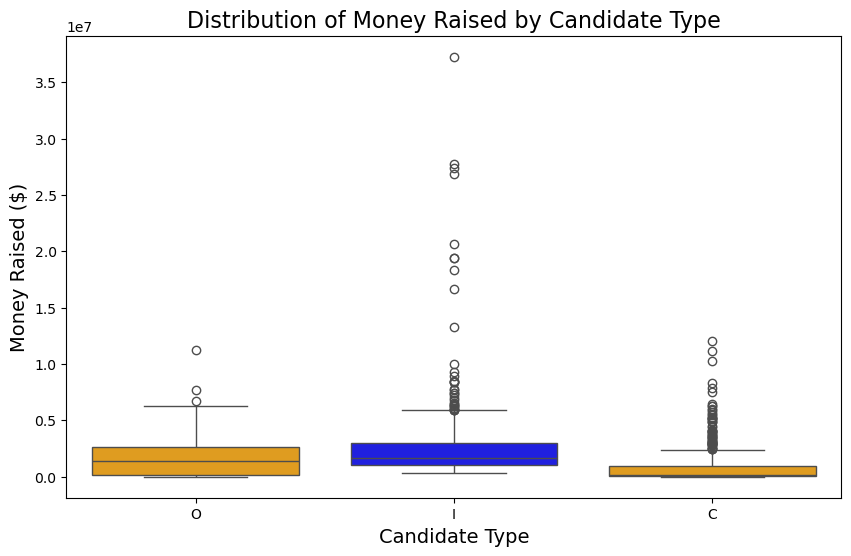

In [31]:
plt.figure(figsize=(10, 6))

custom_palette = {'I': 'blue', 'O': 'orange', 'C': 'orange'}

sns.boxplot(x='Candidate_Type', y='Money_Raised', data=df_clean, hue='Candidate_Type', palette=custom_palette, legend=False)

plt.xlabel('Candidate Type', fontsize=14) 
plt.ylabel('Money Raised ($)', fontsize=14)  

plt.title('Distribution of Money Raised by Candidate Type', fontsize=16)

plt.show()

In [33]:
incumbents = df_clean[df_clean['Candidate_Type'] == 'I']
open = df_clean[df_clean['Candidate_Type'] == 'O']
challenger = df_clean[df_clean['Candidate_Type'] == 'C']

incumbents_money = incumbents['Money_Raised']
open_money = open['Money_Raised']
challenger_money = challenger['Money_Raised']

incumbents_money.describe(), open_money.describe(), challenger_money.describe()

(count    3.850000e+02
 mean     2.813123e+06
 std      3.861846e+06
 min      3.277270e+05
 25%      1.071961e+06
 50%      1.700061e+06
 75%      3.003883e+06
 max      3.726283e+07
 Name: Money_Raised, dtype: float64,
 count    1.090000e+02
 mean     1.740476e+06
 std      1.970974e+06
 min      0.000000e+00
 25%      1.284580e+05
 50%      1.418014e+06
 75%      2.595446e+06
 max      1.123967e+07
 Name: Money_Raised, dtype: float64,
 count    3.980000e+02
 mean     9.195963e+05
 std      1.760100e+06
 min      0.000000e+00
 25%      2.442241e+04
 50%      1.105414e+05
 75%      9.560108e+05
 max      1.205056e+07
 Name: Money_Raised, dtype: float64)

In [39]:
challenger_negative_money = challenger[challenger['Money_Raised'] == 0]

print(challenger_negative_money)

            cid           FirstLastP  Money_Raised  Money_Spent  EndCash  \
55    N00045123     Scott Giblin (R)           0.0       593.86     0.00   
75    N00045124    Alison Hayden (R)           0.0      8357.65  5727.32   
253   N00045680  Theodore Murray (I)           0.0        10.00   499.00   
256   N00047454      K.W. Miller (3)           0.0         0.00   100.00   
823   N00047555  Theresa Everett (I)           0.0         0.00  6873.15   
891   N00043366  Richie Castaldo (L)           0.0      1425.00     0.00   
1039  N00046292      Shawn Kelly (L)           0.0         0.00     0.00   
1092  N00038289       Tom Wakely (3)           0.0         0.00     0.00   
1111  N00045168       Jay Taylor (I)           0.0         0.00     0.00   
1197  N00033103     Andrew Straw (3)           0.0         0.00     0.00   

      LgIndivs  SmIndivs  VotePercent Result Candidate_Type           State  \
55         0.0       0.0        23.20      L              C      California   
75   

Incumbents, on average, raised the most amount of money clocking in at an average of $2.8M raised. Open candidates followed behind with an average of $1.25M and lastly, challenger candidates with $508K. 

Incumbents vary more in the amount of money raised and have the highest std deviation. 



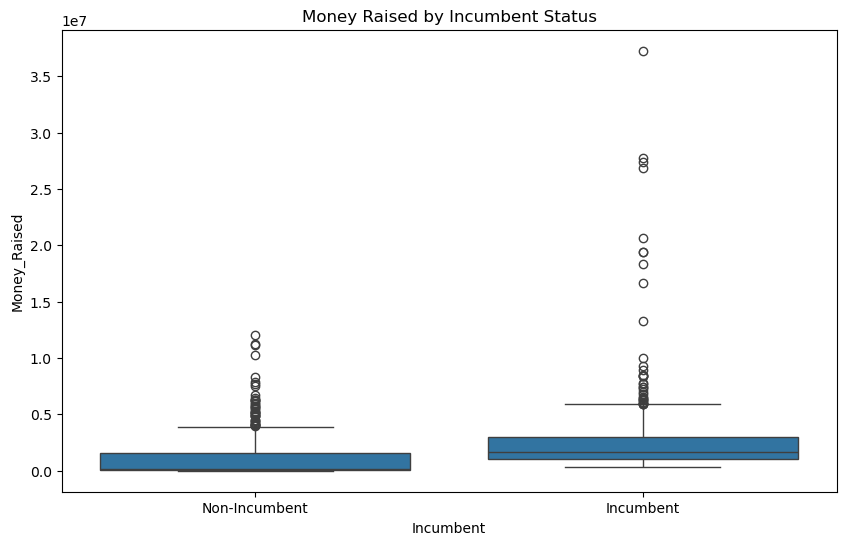

In [20]:
df_clean['Incumbent'] = df_clean['Candidate_Type'].apply(lambda x: 'Incumbent' if x == 'I' else 'Non-Incumbent')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Incumbent', y='Money_Raised', data=df_clean)
plt.title("Money Raised by Incumbent Status")
plt.show()